# Preprocesamiento de Datos - Talento Tech Bogotá

- 1. Limpieza (valores faltantes, outliers, duplicados)
- 2. Feature engineering
- 3. Reducción de dimensionalidad
- 4. Transformación de datos y codificación (encoding)


In [ ]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## Carga de Datos y Trabajo Previo Integrado


In [ ]:
# Cargar datos limpios del trabajo previo en data_preparation.ipynb
print("=== CARGANDO DATOS LIMPIOS DE data_preparation.ipynb ===")

df_cleaning = pd.read_csv('df_clean.csv')
print(f"Dataset limpio cargado: {df_cleaning.shape}")
print(f"Columnas disponibles: {list(df_cleaning.columns)}")

print("\nTransformaciones básicas ya aplicadas en data_preparation.ipynb:")
print("   - Eliminación de columnas irrelevantes (id, departamento, municipio, etc.)")
print("   - Codificación de variables categóricas a numéricas")
print("   - Limpieza de Eje_tematico (eliminación de 'Null')")
print("   - Eliminación de variables constantes")
print("   - Manejo de valores faltantes específicos del dominio")
print(f"   - Resultado: Dataset con {df_cleaning.shape[0]} registros y {df_cleaning.shape[1]} variables")

# Verificar calidad de datos
print(f"\nVerificación de calidad:")
print(f"   - Valores faltantes totales: {df_cleaning.isnull().sum().sum()}")
print(f"   - Variables numéricas: {df_cleaning.select_dtypes(include=[np.number]).shape[1]}")
print(f"   - Variables categóricas: {df_cleaning.select_dtypes(include=['object']).shape[1]}")


=== CARGANDO DATOS LIMPIOS DE data_preparation.ipynb ===
Dataset limpio cargado: (3110, 45)
Columnas disponibles: ['Genero', 'Campesino', 'Estrato', 'Autoidentificacion_Etnica', 'NIvel_educacion', 'Discapacidad', 'Tipo_formacion', 'Victima_del_conflicto', 'Disponibilidad_Equipo', 'tiempo_segundos', 'Eje_tematico', 'Eje Final', 'Puntaje_eje_tematico_selecionado', 'linea_1_programacion', 'linea_2_inteligecia_artificial', 'linea_3_analisis_de_datos', 'linea_4_blockchain', 'linea_5_arquitectura_en_la_nube', 'linea_1_des_programacion', 'linea_2_des_inteligecia_artificial', 'linea_3_des_analisis_de_datos', 'linea_4_des_blockchain', 'linea_5_des_arquitectura_en_la_nube', 'area_1_alfabetizacion_datos', 'area_2_comunicacion_y_colaboracion', 'area_3_contenidos_digitales', 'area_4_seguridad', 'area_5_solucion_de_problemas', 'area_6_igles', 'area_1_des_alfabetizacion_datos', 'area_2_des_comunicacion_y_colaboracion', 'area_3_des_contenidos_digitales', 'area_4_des_seguridad', 'area_5_des_solucion_de

## 1. Limpieza de Datos Avanzada

Aunque ya se realizó limpieza básica, necesitamos un análisis sistemático de outliers, duplicados y valores faltantes para garantizar la calidad de los datos. Esto es fundamental para el rendimiento de los modelos de machine learning.


In [ ]:
# Análisis de valores faltantes
print("=== ANÁLISIS DE VALORES FALTANTES ===")

missing_values = df_cleaning.isnull().sum()
print(f"Total de valores faltantes: {missing_values.sum()}")

if missing_values.sum() > 0:
    print("\nVariables con valores faltantes:")
    print(missing_values[missing_values > 0])
else:
    print("No hay valores faltantes en el dataset")


=== ANÁLISIS DE VALORES FALTANTES ===
Total de valores faltantes: 123

Variables con valores faltantes:
Genero              23
tiempo_segundos    100
dtype: int64


In [ ]:
# Detección básica de outliers
print("\n=== DETECCIÓN DE OUTLIERS ===")

# Analizar outliers en variable de puntuación (la más importante)
if 'Puntaje_eje_tematico_selecionado' in df_cleaning.columns:
    Q1 = df_cleaning['Puntaje_eje_tematico_selecionado'].quantile(0.25)
    Q3 = df_cleaning['Puntaje_eje_tematico_selecionado'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_cleaning[(df_cleaning['Puntaje_eje_tematico_selecionado'] < lower_bound) | 
                          (df_cleaning['Puntaje_eje_tematico_selecionado'] > upper_bound)]
    
    print(f"Outliers detectados en Puntaje: {len(outliers)} ({(len(outliers)/len(df_cleaning)*100):.1f}%)")
    print(f"Rango normal: [{lower_bound:.1f}, {upper_bound:.1f}]")
else:
    print("Variable de puntuación no encontrada")



=== DETECCIÓN DE OUTLIERS ===
Outliers detectados en Puntaje: 0 (0.0%)
Rango normal: [-23.9, 143.9]


## 2. Feature Engineering

Creamos nuevas características derivadas que capturan patrones complejos en los datos, como promedios, desviaciones, ratios y características de perfil demográfico que pueden ser predictores importantes del éxito académico.


In [ ]:
# Crear copia para feature engineering
df_fe = df_cleaning.copy()
print(f"Dataset inicial para feature engineering: {df_fe.shape}")

# Características derivadas - Promedios de puntuaciones
print("\n=== CREANDO CARACTERÍSTICAS DERIVADAS ===")

# Promedio de líneas temáticas
linea_cols = [col for col in df_fe.columns if col.startswith('linea_') and not col.endswith('_des')]
if len(linea_cols) > 0:
    df_fe['promedio_lineas'] = df_fe[linea_cols].mean(axis=1)
    print(f"Promedio de líneas temáticas creado")

# Promedio de áreas de competencia
area_cols = [col for col in df_fe.columns if col.startswith('area_') and not col.endswith('_des')]
if len(area_cols) > 0:
    df_fe['promedio_areas'] = df_fe[area_cols].mean(axis=1)
    print(f"Promedio de áreas de competencia creado")


Dataset inicial para feature engineering: (3110, 45)

=== CREANDO CARACTERÍSTICAS DERIVADAS ===
Promedio de líneas temáticas creado
Promedio de áreas de competencia creado


In [ ]:
# Variable de éxito académico (variable objetivo)
print("\n=== CREANDO VARIABLE OBJETIVO ===")

# Variable binaria de éxito (FORMADO = 1, otros = 0)
if 'Estado (FORMADO, NO APROBADO, INACTIVO, EN FORMACION)' in df_fe.columns:
    df_fe['exito_academico'] = (df_fe['Estado (FORMADO, NO APROBADO, INACTIVO, EN FORMACION)'] == 1).astype(int)
    print(f"Variable 'exito_academico' creada")
    print(f"   - Estudiantes con éxito: {df_fe['exito_academico'].sum()}")
    print(f"   - Estudiantes sin éxito: {(df_fe['exito_academico'] == 0).sum()}")

# Ratio de asistencia
if 'Asistencia horas' in df_fe.columns and 'Total_horas posibles' in df_fe.columns:
    df_fe['ratio_asistencia'] = df_fe['Asistencia horas'] / df_fe['Total_horas posibles'].replace(0, 1)
    df_fe['ratio_asistencia'] = df_fe['ratio_asistencia'].fillna(0)
    print(f"Variable 'ratio_asistencia' creada")

print(f"\nTotal de nuevas características: {df_fe.shape[1] - df_cleaning.shape[1]}")



=== CREANDO VARIABLE OBJETIVO ===
Variable 'exito_academico' creada
   - Estudiantes con éxito: 912
   - Estudiantes sin éxito: 2198
Variable 'ratio_asistencia' creada

Total de nuevas características: 4


## 3. Reducción de Dimensionalidad

Con muchas variables creadas, necesitamos reducir la dimensionalidad para evitar la maldición de la dimensionalidad y mejorar el rendimiento de los modelos. PCA nos permite mantener la información más importante mientras reducimos el número de características, y t-SNE nos ayuda a visualizar patrones complejos en los datos.


In [ ]:
# Análisis de Componentes Principales (PCA) simplificado
print("=== ANÁLISIS PCA ===")

# Seleccionar variables numéricas
numeric_features = df_fe.select_dtypes(include=[np.number]).columns
print(f"Variables numéricas: {len(numeric_features)}")

# Verificar y eliminar NaN antes de PCA
df_pca = df_fe[numeric_features].copy()
print(f"NaN encontrados: {df_pca.isnull().sum().sum()}")

# Llenar NaN con la mediana de cada columna
if df_pca.isnull().sum().sum() > 0:
    df_pca = df_pca.fillna(df_pca.median())
    print(f"NaN después de imputación: {df_pca.isnull().sum().sum()}")

# Estandarizar
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Aplicar PCA
pca = PCA(n_components=0.90)  # Mantener 90% de varianza
pca_result = pca.fit_transform(df_scaled)

print(f"Componentes originales: {df_scaled.shape[1]}")
print(f"Componentes después de PCA: {pca_result.shape[1]}")
print(f"Varianza explicada: {pca.explained_variance_ratio_.sum():.2%}")


=== ANÁLISIS PCA ===
Variables numéricas: 49
NaN encontrados: 123
NaN después de imputación: 0
Componentes originales: 49
Componentes después de PCA: 18
Varianza explicada: 90.13%


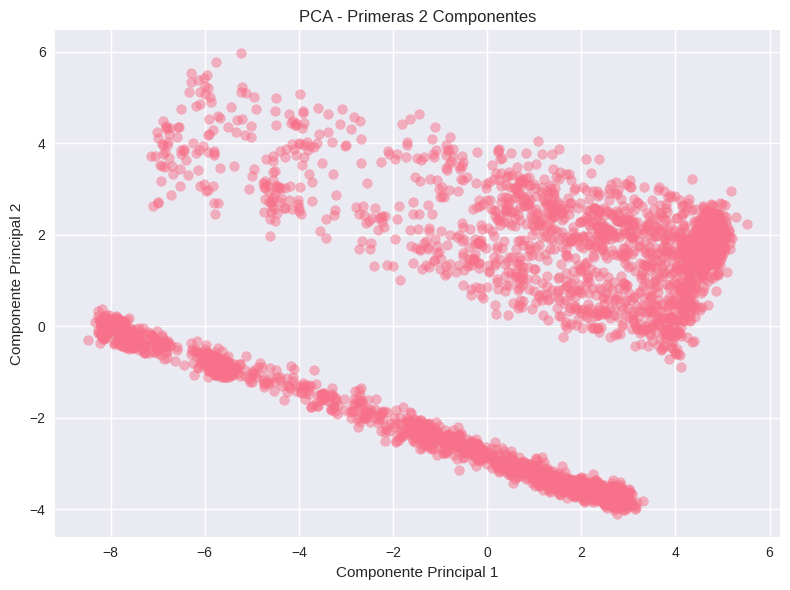

In [ ]:
# Visualización simple de PCA
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - Primeras 2 Componentes')
plt.grid(True)
plt.tight_layout()
plt.show()



=== ANÁLISIS DE CORRELACIONES ===


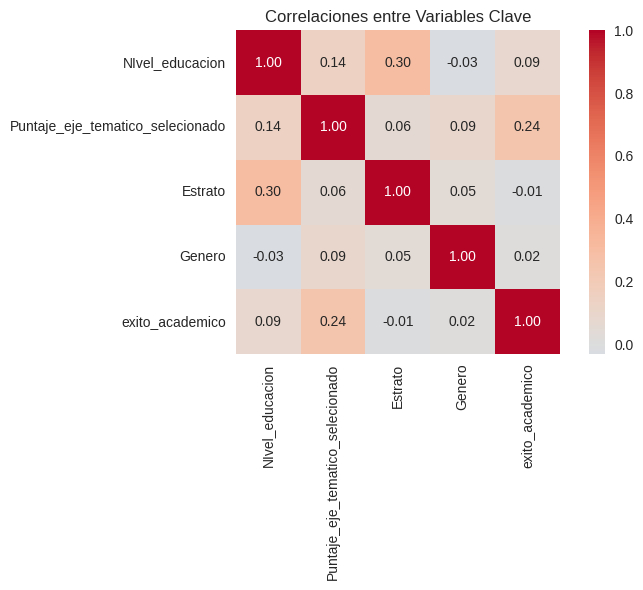

Matriz de correlación generada


In [ ]:
# Análisis de correlaciones importante
print("\n=== ANÁLISIS DE CORRELACIONES ===")

# Calcular correlaciones de variables clave con éxito académico
if 'exito_academico' in df_fe.columns:
    important_vars = ['NIvel_educacion', 'Puntaje_eje_tematico_selecionado', 
                     'Estrato', 'Genero', 'exito_academico']
    
    # Filtrar variables que existen
    available_vars = [v for v in important_vars if v in df_fe.columns]
    
    if len(available_vars) > 2:
        corr_matrix = df_fe[available_vars].corr()
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                   square=True, fmt='.2f')
        plt.title('Correlaciones entre Variables Clave')
        plt.tight_layout()
        plt.show()
        
        print("Matriz de correlación generada")


## 4. Transformación de Datos y Codificación (Encoding)

Para que los algoritmos de machine learning funcionen correctamente, necesitamos estandarizar las variables numéricas y codificar las categóricas. La estandarización asegura que todas las variables tengan la misma escala, mientras que el encoding permite que los algoritmos procesen variables categóricas de manera efectiva.


In [ ]:
# Crear dataset final para modelado
df_final = df_fe.copy()
print(f"Dataset inicial: {df_final.shape}")

# Estandarización simple
print("\n=== ESTANDARIZACIÓN ===")

# Identificar variables numéricas
numeric_cols = df_final.select_dtypes(include=[np.number]).columns

# Variables binarias que NO se estandarizan
binary_cols = ['Genero', 'Campesino', 'Victima_del_conflicto', 'Disponibilidad_Equipo', 
               'Matriculado (SI o NO)', 'exito_academico']

# Variables a estandarizar
cols_to_scale = [col for col in numeric_cols if col not in binary_cols]

# Aplicar estandarización
scaler_final = StandardScaler()
df_final[cols_to_scale] = scaler_final.fit_transform(df_final[cols_to_scale])

print(f"{len(cols_to_scale)} variables estandarizadas")


Dataset inicial: (3110, 49)

=== ESTANDARIZACIÓN ===
43 variables estandarizadas


In [ ]:
# Verificación y guardado
print("\n=== VERIFICACIÓN FINAL ===")

# Verificar calidad
print(f"Forma final: {df_final.shape}")
print(f"Valores NaN: {df_final.isnull().sum().sum()}")
print(f"Variables numéricas: {df_final.select_dtypes(include=[np.number]).shape[1]}")

# Guardar dataset procesado
df_final.to_csv('df_processed_final.csv', index=False)
print("\nDataset guardado como 'df_processed_final.csv'")



=== VERIFICACIÓN FINAL ===
Forma final: (3110, 49)
Valores NaN: 123
Variables numéricas: 49

Dataset guardado como 'df_processed_final.csv'
